Harika—“minimum ama kritik” düzeltmeleri ekleyerek **tek bir uçtan-uca script** yaptım.

* ID/etiket sızıntısı yok
* `input_len` dinamik
* SOM deterministik (`random_seed`) ve `train_batch` ile daha stabil
* Fraud üyelik kontrolü **index** üzerinden güvenli
* ANN tarafında **train/test ayrımı** ve **scaler sadece train ile fit**

> Gerekli: `pip install minisom tensorflow scikit-learn pandas matplotlib`

[INFO] X shape: (690, 14), IDs: (690,), y(approval): (690,)


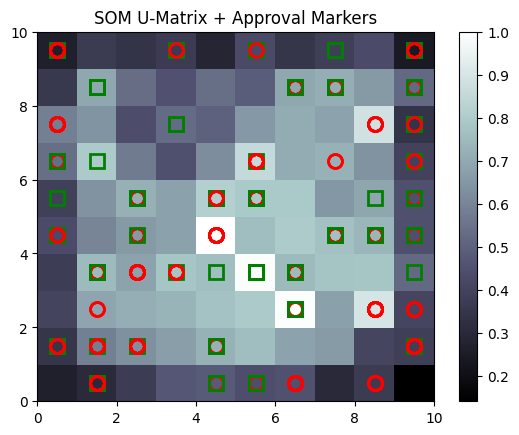

[INFO] Seçilen şüpheli node sayısı: 4 | Toplam işaretlenen örnek: 19
[INFO] Fraud ID'ler (ilk 20): [15715750, 15789201, 15654859, 15723827, 15585192, 15566495, 15701081, 15725028, 15611318, 15731989, 15690898, 15622507, 15640521, 15800049, 15659031, 15777893, 15801817, 15725002, 15667460]
[INFO] Weak labels -> fraud=1 sayısı: 19, normal=0 sayısı: 671
5/5 [==============================] - 0s 4ms/step

[TOP RISK - TEST] İlk 20 müşteri (score'a göre):
 CustomerID  weak_label_outlier    score
   15677395                   0 0.176161
   15611318                   1 0.163919
   15744044                   0 0.160672
   15747757                   0 0.134946
   15774262                   0 0.127273
   15663194                   0 0.113294
   15768449                   0 0.113232
   15723827                   1 0.112194
   15723884                   0 0.110809
   15728082                   0 0.106233
   15780088                   0 0.094641
   15775750                   0 0.087389
   15715750  

In [1]:

# som_credit_pipeline_clean.py
# ---------------------------------
# UCI Statlog Australian Credit (kurstaki Credit_Card_Applications.csv formatı)
# 1) SOM ile U-Matrix görselleştirme + şüpheli (node) seçimi
# 2) Seçilen node'lardaki örneklerden "weak label" üretip ANN ile risk skoru

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from minisom import MiniSom
import tensorflow as tf
from tensorflow.keras import layers, models

# =========================
# 0) Veriyi oku ve sütunları ayır
# =========================
# CSV düzeni: [CustomerID | ... features ... | Approval(y)]
df = pd.read_csv("Credit_Card_Applications.csv")

ids        = df.iloc[:, 0].values        # CustomerID
y_approval = df.iloc[:, -1].values       # Onay etiketi (sadece görselleştirme/analiz)
X          = df.iloc[:, 1:-1].values     # Özellikler: ID ve y hariç

print(f"[INFO] X shape: {X.shape}, IDs: {ids.shape}, y(approval): {y_approval.shape}")

# =========================
# 1) SOM için ölçekleme (MinMax)
# =========================
mm = MinMaxScaler()
X_mm = mm.fit_transform(X)

# =========================
# 2) SOM eğitimi (deterministik ve daha stabil)
# =========================
m, n = 10, 10                         # Grid boyutu (isteğe göre)
input_len = X_mm.shape[1]
som = MiniSom(x=m, y=n, input_len=input_len, sigma=1.0, learning_rate=0.5, random_seed=42)
som.random_weights_init(X_mm)
som.train_batch(X_mm, num_iteration=200)  # train_random yerine batch, daha stabil/tekrarlanabilir

# =========================
# 3) U-Matrix görselleştirme + onay/ret markerları
# =========================
from pylab import bone, pcolor, colorbar, plot, show

bone()
umatrix = som.distance_map().T  # U-Matrix (komşu prototip mesafeleri)
pcolor(umatrix)
colorbar()
markers = ['o', 's']   # 0 = daire, 1 = kare (approval kolonu 0/1 ise)
colors  = ['r', 'g']   # 0 = kırmızı, 1 = yeşil

# Her örnek için BMU bul → o koordinata marker çiz
for i, x in enumerate(X_mm):
    w = som.winner(x)  # (i,j)
    plot(w[0] + 0.5,
         w[1] + 0.5,
         markers[int(y_approval[i])],
         markeredgecolor=colors[int(y_approval[i])],
         markerfacecolor='None',
         markersize=10,
         markeredgewidth=2)
plt.title("SOM U-Matrix + Approval Markers")
show()

# =========================
# 4) BMU (kazanan düğüm) koordinatları ve index haritası
# =========================
winners = [som.winner(x) for x in X_mm]   # her örnek için (i,j)
# node -> örnek indeksleri
node_to_indices = {}
for idx, w in enumerate(winners):
    node_to_indices.setdefault(w, []).append(idx)

# =========================
# 5) Şüpheli node'ları seç (U-Matrix’e bakarak MANUEL seçim)
#    Not: Bu listeyi U-Matrix'e göre kendin belirle; aşağıda örnekler var.
# =========================
# ÖRNEK (kurs videolarındaki gibi bazı açık (açık ton) hücreler):
suspect_nodes = {(1, 8), (7, 8), (8, 3), (8, 8)}  # tekrarlar gereksiz, set yeterli
fraud_indices = []
for node in suspect_nodes:
    fraud_indices.extend(node_to_indices.get(node, []))  # node boşsa atla

fraud_indices = sorted(set(fraud_indices))
print(f"[INFO] Seçilen şüpheli node sayısı: {len(suspect_nodes)} | Toplam işaretlenen örnek: {len(fraud_indices)}")

# İlgili CustomerID'leri çıkar
fraud_id_list = ids[fraud_indices]
print("[INFO] Fraud ID'ler (ilk 20):", fraud_id_list[:20].tolist())

# =========================
# 6) Weak label vektörü oluştur (is_fraud)
# =========================
fraud_id_set = set(int(i) for i in fraud_id_list)   # güvenli set
is_fraud = np.array([1 if int(ids[i]) in fraud_id_set else 0 for i in range(len(ids))], dtype=int)
print(f"[INFO] Weak labels -> fraud=1 sayısı: {is_fraud.sum()}, normal=0 sayısı: {(len(is_fraud)-is_fraud.sum())}")

# =========================
# 7) ANN için train/test ayrımı (leakage yok)
# =========================
X_tr, X_te, y_tr, y_te, ids_tr, ids_te = train_test_split(
    X, is_fraud, ids, test_size=0.2, random_state=42, stratify=is_fraud if is_fraud.sum() > 0 else None
)

sc = StandardScaler()
X_tr_sc = sc.fit_transform(X_tr)   # scaler sadece train ile fit
X_te_sc = sc.transform(X_te)

# =========================
# 8) Basit ANN (weak label ile risk skoru)
# =========================
tf.random.set_seed(42)
ann = models.Sequential([
    layers.Dense(16, activation='relu', input_shape=(X_tr_sc.shape[1],)),
    layers.Dropout(0.2),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
ann.compile(optimizer='adam', loss='binary_crossentropy')

ann.fit(X_tr_sc, y_tr, epochs=15, batch_size=16, verbose=0)

# Test skorları (olasılık)
y_score_te = ann.predict(X_te_sc).ravel()

rank_te = pd.DataFrame({
    "CustomerID": ids_te,
    "weak_label_outlier": y_te,
    "score": y_score_te
}).sort_values("score", ascending=False)

print("\n[TOP RISK - TEST] İlk 20 müşteri (score'a göre):")
print(rank_te.head(20).to_string(index=False))

# (Opsiyonel) Tüm dataset için skor üretmek istersen:
X_all_sc = sc.transform(X)                      # DİKKAT: sc sadece train ile fit edilmişti
y_score_all = ann.predict(X_all_sc).ravel()
rank_all = pd.DataFrame({
    "CustomerID": ids,
    "weak_label_outlier": is_fraud,
    "score": y_score_all
}).sort_values("score", ascending=False)

print("\n[TOP RISK - ALL] İlk 20 müşteri (score'a göre):")
print(rank_all.head(20).to_string(index=False))


## Nasıl kullanacaksın?

1. `suspect_nodes` listesini **U-Matrix’e bakarak** (açık tonlu bölgeler/sınırlar) kendine göre güncelle.
2. Çalıştır: önce harita gelir, sonra konsolda **işaretlenen örnek sayısı, fraud ID’ler** ve **risk sıralamaları** yazdırılır.
3. ANN tarafında scaler sadece **train** ile fit edilir → **leakage yok**.

## Sonraki turda (kurs bitince) ekleyebileceğin gelişmişler

* **Otomatik aykırı seçim:** BMU mesafesi %95 persentil + düşük yoğunluklu node’lar
* **K-Means ile prototip kümeleme:** `som.get_weights().reshape(m*n, -1)` üzerinde `k-means++` + Elbow/Silhouette
* **One-Hot + (opsiyonel) PCA**: karma tip veri için daha sağlam temsil

İstersen, bir sonraki adımda **“otomatik aykırı eşiği (%95)”** sürümünü de ekleyebilirim; tek bir bayrakla (`USE_AUTO_OUTLIER=True`) açıp kapatırız.
